# Proof-of-concept: Company name mapping

This jupyter notebook is used as a fully-documented proof-of-concept for a case study I was given during a job interview.  


<!-- Different concepts/approaches/solutions are tested, evaluated and documented.
 -->

## 1. Presentation of the study case


The case study is quite simple. A list of company names is provided. All these names were manually written. As a result, some of the names refer to the same entity but written differently. For instance, division names are written alongside the company name (i.e. ALTRAN INNOVACION for ALTRAN). Or the names can be written in non-standard way, with non-english characters or with common naming (i.e. 'INC.' or '& CO').The goal is to group the names from the same entity. 

As examples:
- `ALTERYX` is equivalent to `ALTERYX, INC`
- `ALTRAN INNOVACIÃƒÂ“N S.L.` is equivalent to `ALTRAN INNOVACION SOCIEDAD LIMITADA`
- `AMICALE DES ANCIENS DU STADE` is different from `AMICALE JEAN BAPTISTE SALIS`

An algorithm need then to be designed to efficiently map the names to their common entity, possibly written in a standardized way. Several answers can be given for a given name in order to let the user easily choose the proper entity name. 

The case study comes with a dataset of 5000 raw company names, but the algorithm is required to be scalable to larger datasets (e.g. 100,000 names). 

## 2. Analyzing the problem

This study case can be considered as a natural language processing (NLP) problem. Though, unlike a typical NLP problem, this one has the particularity of involving unsupervised machine learning techniques. There is no "true" answer given for each company name in the dataset, and therefore one has to find a way to clusterize the names based on a metric that should quantify how likely two names are coming from the same entity. The choice of this  metric is therefore probably as important as the choice of the clustering algorithm. 

<!-- Different metrics could be tested and can be chosen as function as the overall performance of the algorithm (efficiency and speed). 
 -->
 
One additional important step  of the algorithm will be the data pre-processing. Many raw company names are given in a non-standard way, with sometimes special characters like non-english characters, commas, dots, quotes, etc. A special care is then needed to clean the data and format them in a suitable  way for the clustering algorithm. A possible step could be to remove to recurrent names that would not help the string metric (e.g. 'Inc.'). The list of these names could be found by listing the most recurrent sub-string in the dataset and by manually choosing the ones that will be removed. 

The output of the algorithm need to allow the user to choose himself the correct entity from a list of proposals. This feature will drive the choice of the clustering algorithm. For instance, a hierarchical clustering will allow to organize the names into dendogram which would give the possibility of having several possible "layers" of clusters.

Evaluating the performance of the algorithm is required. Two metrics will have to be assessed: 
 * The efficiency of the algorithm to properly map the name to the correct entity. Since we don't have the true answers, this will need to be manually evaluated. A possible way would be to choose N (e.g. 20) randomly-chosen names, define their true entity and check if it appears in the output of the algorithm. 
 * The speed of the algorithm, and an estimation of the time to process a dataset of 100,000 names.
 
After some research, I found a few solutions that were already proposed for similar problems:
 * [Company Names Standardization using a Fuzzy NLP Approach](https://rajanarya.com/2020/03/28/company-names-standardization-using-a-fuzzy-nlp-approach/) and [Supplier Name Standardization using Unsupervised Learning](https://medium.com/analytics-vidhya/supplier-name-standardization-using-unsupervised-learning-adb27bed9e0d). Their approach identifies 'stop-words' (common terms), removes them from the data, defines a pairwize similarity matrix bazed on a fuzzy matching of strings, clusterizes the names based on this matrix using the Affinity clustering technique and find the most commonly occuring longest common string for each cluster. While these solutions are inspiring, it is not clear if they are fast enough to be used for a large number of names.
 * [Deduping & Record Linkage](https://www.kaggle.com/caesarlupum/deduping-record-linkage) and [Super Fast String Matching in Python](https://bergvca.github.io/2017/10/14/super-fast-string-matching.html). Their approach uses a faster technique to quantify similiarities between two names. They use the TF-IDF method applied to the N-gram approach. This allows to define a vector of features for each name and use the cosine distance as input for the clustering technique. 
 
In addition, I found large company name datasets which could be used for testing the algorithm: 
 * A dataset of 663000 names from the US : https://www.kaggle.com/dattapiy/sec-edgar-companies-list 
 * A dataset of nearly 2M names (!!) from India registered between 1857 and 2020: https://www.kaggle.com/rowhitswami/all-indian-companies-registration-data-1900-2019

## 3. Pre-processing the data

Importing the necessary libraries first:

In [1]:
import numpy as np
import pandas as pd
import re
import string
import nltk

Extract the raw name dataset as a pandas serie object:

In [2]:
dfs = pd.read_excel("Case_study_names_mapping.xlsx", usecols=[0])
data = dfs['Raw name']
data.head(10)

0          "ACCESOS NORMALIZADOS, SL"
1       "ALTAIX ELECTRONICA , S.A.L."
2      "ANTALA LOCKS & ACCESORIS, SL"
3                       "ANTERAL, SL"
4        "ARQUIMEA INGENIERIA , S.L."
5    A & D ENVIRONMENTAL SERVICES LTD
6                      A & L GOODBODY
7                      A & P - LITHOS
8    A & T STATIONERS PRIVATE LIMITED
9              A A LOGISTIK-EQUIPMENT
Name: Raw name, dtype: object

Encoding issues can already be found for some of the names: 

In [3]:
data.at[1255]

'AHP Gesellschaft fÃ\x83Â¼r Informationsverarbeitung mbH'

This is probably coming from non-english characters. The data are uniformized and encoded into utf-8: 

In [4]:
data_clean = data.str.normalize('NFKD').str.encode("ascii",'ignore').str.decode("utf-8","ignore")
data_clean.at[1255]

'AHP Gesellschaft fAA14r Informationsverarbeitung mbH'

This preserves the presence of unrecognized characters. This is not perfect, but it will do the job for now.

The characters are then lowered:

In [5]:
data_clean = data_clean.str.lower()
data_clean.at[1255]

'ahp gesellschaft faa14r informationsverarbeitung mbh'

Next, the special characters are removed. The list of ponctuation characters are extracted from `string`. The ampersand symbol (i.e. `&`) is removed from this list as this is a common character used for company names (e.g. AT&T) which can be a useful information for the clustering algorithm.    

In [6]:
punctuation_custom = string.punctuation.replace('&','') # !"#$%'()*+,-./:;<=>?@[\]^_`{|}~
data_clean = data_clean.apply(lambda x: re.sub('[%s]'%re.escape(punctuation_custom), '' , x)) ## ponctuation
data_clean = data_clean.apply(lambda x: re.sub('  ', ' ' , x)) ## remove double space
data_clean.head(10)

0             accesos normalizados sl
1              altaix electronica sal
2         antala locks & accesoris sl
3                          anteral sl
4              arquimea ingenieria sl
5    a & d environmental services ltd
6                      a & l goodbody
7                        a & p lithos
8    a & t stationers private limited
9               a a logistikequipment
Name: Raw name, dtype: object

To find the stop-words in the raw names, the most frequent words are first listed:

In [7]:
words = data_clean.str.cat(sep=' ').split()
word_dist = nltk.FreqDist(words)

rslt = pd.DataFrame(word_dist.most_common(25),
                    columns=['Word', 'Frequency'])
print(rslt)

            Word  Frequency
0           gmbh        798
1              &        263
2            ltd        234
3             de        162
4             co        140
5            inc        131
6    association        126
7             sl        123
8             kg        114
9             sa        113
10           sas         95
11      autohaus         93
12      services         84
13       limited         80
14         group         71
15        france         66
16             a         61
17  technologies         59
18           und         57
19       systems         57
20     solutions         56
21    consulting         55
22           llc         49
23      advanced         45
24          sarl         44


The stop-words are then manually chosen by checking all the cells that contains these words. E.g.

In [8]:
data_clean[data_clean.str.contains("kg")].head(20)

52                 a&e logistik gmbh & co kg
74                    as frucht gmbh & co kg
296            absolut karriere gmbh & co kg
303                       abtec gmbh & co kg
357                     accemic gmbh & co kg
512                        acsg gmbh & co kg
568                  active blue gmbh & cokg
569                  active blue gmbh & cokg
621           adalbert zajadacz gmbh & co kg
624     adam keller baugeschaft gmbh & co kg
625    adam keller baugeschaeft gmbh & co kg
627               adams consult gmbh & co kg
645                         adc gmbh & co kg
720               adex beratungs gmbh & cokg
789                    adolf lupp gmbh co kg
790               adolf mueller gmbh & co kg
792                    adolf reiss & sohn kg
794                 adolf warth gmbh & co kg
796                  adolf wrth gmbh & co kg
797                adolf wuerth gmbh & co kg
Name: Raw name, dtype: object

In [9]:
stop_words = ["gmbh", "& co", "co", "kg", "cokg", "ltd", "limited", "sl", "inc", "sa", "sarl", "sas", "llc", "dba"]
data_clean = data_clean.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
data_clean.head(20)

0             accesos normalizados
1           altaix electronica sal
2         antala locks & accesoris
3                          anteral
4              arquimea ingenieria
5     a & d environmental services
6                   a & l goodbody
7                     a & p lithos
8         a & t stationers private
9            a a logistikequipment
10                a a z consulting
11                a and m portable
12                      a arnegger
13                 a b fluid power
14                a bis z allround
15                     a e petsche
16                  a e petsche uk
17                   a et p lithos
18              a foubert visserie
19                   a joy wallace
Name: Raw name, dtype: object

The country names (e.g. `france`) could possibly be removed, but some of the entity contain the country name (e.g. `AGENCE FRANCE-PRESSE`). 

In the future, some tests could be done by using a more aggressive stop-words cleaning (e.g. removing other common words such as `technologies`, `services`, `systems`, `solutions`, `consulting`, etc). 

## 4. Finding the good name-similarity metric

The choice of the name-similarity metric is one of the main challenge of this assignment. The metric should be able to quantify how likely two names are from the same entity. However, the clustering algorithm will need to compute the similiarity between ALL pairs of names. This is equivalent of computing the similarity matrix $d$ of shape (m,m), where m is the number of names and $d_{ij}$ is the similarity score between the names $i$ and $j$. Even after assuming that a symmetric matrix with the diagonal terms equaled to 1, this consists of computing m(m-1)/2 terms. The metric has then to be defined such as the computation of this matrix is performed in an efficient and fast way, possibly using a vectorized method.

Importing the necessary libraries:

In [10]:
import Levenshtein as lev
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

From the [fuzzy matching](https://rajanarya.com/2020/03/28/company-names-standardization-using-a-fuzzy-nlp-approach/) method and the general documentation on [string metric](https://en.wikipedia.org/wiki/String_metric), one possible approach is to use one of the string simalirity metric such as the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance). This method basically counts how many text changes are needed to transform a word A to a word B. Even if methods can be used to speed-up the computation of this metric, this approach can only be performed after looping over all possible pair of names. This number of operation would then increase quadratically with the size of the dataset. It is clear that the computation time will explode for large datasets. For the current dataset, the simple operation below took more than 3min. For more than 100 000 names, this approach would take several days.

In [11]:
%%time

size_data = data_clean.shape[0] #500
distance_matrix_lev = np.zeros((size_data, size_data))

for i in range(size_data):
    for j in range(i+1, size_data):
        distance_matrix_lev[i,j] = lev.ratio(data_clean.at[i], data_clean.at[j])

CPU times: user 3min 18s, sys: 432 ms, total: 3min 18s
Wall time: 4min 5s


An alternative approach is to transform the string into a vector of features (i.e. list of numerical values) and to build the similarity matrix by simply performing the dot product between two matrices. When M is a matrix of shape (m,n) where m is the number of names and n is the number of features, the similarity matrix is defined as $d = M.M^{T}$. This is a vectorized approach.

Following the method used by this [solution](https://bergvca.github.io/2017/10/14/super-fast-string-matching.html), I decided to vectorize the dataset using the [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) method from the sklearn librairy. This allow us to use N-gram approach to define the vector of features as the list of combination of 3 letters. Each feature value is quantified using the [TF-ITF](https://en.wikipedia.org/wiki/Tf-idf) approach to reduce the importance of common combinations. This feature extraction takes less than 200ms for the entire current dataset.

In [12]:
%%time
vectorizer = TfidfVectorizer(min_df=1, analyzer='char_wb', ngram_range=(3,3))
tf_idf_matrix = vectorizer.fit_transform(data_clean)

CPU times: user 173 ms, sys: 3.9 ms, total: 177 ms
Wall time: 333 ms


The result is a sparse (i.e. with many zeros) matrix of dimension (m,n) with m is the number of names and n is the number of features. Sparse (called CSR here) matrices are handled nicely by the scipy and sklearn libraries.

In [13]:
print(tf_idf_matrix.shape, type(tf_idf_matrix))

(4895, 5231) <class 'scipy.sparse.csr.csr_matrix'>


The list of combination of letters considered as features are shown below. There are in total more than 5000 features, which is a reasonable number to consider for a machine learning problem. If needed, this number can be reduced by removing the combination that appeared only once in the entire dataset or by removing some characters such as space or the numbers. For now, these characters are kept as they can be useful features for the clustering step. 

In [14]:
print(vectorizer.get_feature_names())

[' & ', ' &c', ' 1 ', ' 13', ' 2 ', ' 20', ' 3 ', ' 31', ' 33', ' 35', ' 36', ' 3a', ' 3d', ' 3m', ' 41', ' 42', ' 44', ' 4d', ' 52', ' 56', ' 80', ' 92', ' a ', ' a&', ' a1', ' a2', ' a3', ' aa', ' ab', ' ac', ' ad', ' ae', ' af', ' ag', ' ah', ' ai', ' aj', ' ak', ' al', ' am', ' an', ' ao', ' ap', ' aq', ' ar', ' as', ' at', ' au', ' av', ' aw', ' ax', ' ay', ' az', ' b ', ' ba', ' be', ' bf', ' bg', ' bh', ' bi', ' bl', ' bo', ' br', ' bt', ' bu', ' bv', ' by', ' c ', ' ca', ' ce', ' ch', ' ci', ' cl', ' co', ' cr', ' cs', ' ct', ' cu', ' cv', ' cy', ' d ', ' d&', ' da', ' dc', ' de', ' dg', ' dh', ' di', ' dj', ' dm', ' do', ' dp', ' dr', ' du', ' dv', ' dy', ' e ', ' ea', ' eb', ' ec', ' ed', ' ef', ' eg', ' eh', ' ei', ' ek', ' el', ' em', ' en', ' ep', ' eq', ' er', ' es', ' et', ' eu', ' ev', ' ew', ' ex', ' f ', ' fa', ' fb', ' fe', ' fh', ' fi', ' fl', ' fm', ' fo', ' fr', ' fu', ' fz', ' g ', ' ga', ' gb', ' ge', ' gg', ' gi', ' gl', ' gm', ' gn', ' go', ' gr', ' gs', ' gt'

The result of the feature extraction can be visualized for some of the names. Below, the features for the first name (i.e. `ACCESOS NORMALIZADOS, SL`) in the dataset are shown. A total of 18 features have non-zero values and their values depends on how common these features are. The has `os ` a high value as it appear twice in the name and `zad` has a large value as it is an uncommon sequence. ` ac` seems to be a common sequence.

In [15]:
print(data.at[0])
print(vectorizer.build_analyzer()(data_clean.at[0]))
print(tf_idf_matrix[0,:])
print(vectorizer.inverse_transform(tf_idf_matrix[0,:]))

"ACCESOS NORMALIZADOS, SL"
[' ac', 'acc', 'cce', 'ces', 'eso', 'sos', 'os ', ' no', 'nor', 'orm', 'rma', 'mal', 'ali', 'liz', 'iza', 'zad', 'ado', 'dos', 'os ']
  (0, 1541)	0.252414682317295
  (0, 674)	0.21565822096265796
  (0, 5159)	0.30911941322648145
  (0, 2627)	0.26867881810849703
  (0, 2908)	0.2730144842082469
  (0, 816)	0.18602327881093528
  (0, 3053)	0.2612920061904658
  (0, 4043)	0.1793119099907997
  (0, 3634)	0.19264813615523624
  (0, 3368)	0.21868545601944617
  (0, 225)	0.2208514110724813
  (0, 3643)	0.34306698416265224
  (0, 4333)	0.2730144842082469
  (0, 1850)	0.23107120632462214
  (0, 1287)	0.17182680531470024
  (0, 1267)	0.21663989556604651
  (0, 640)	0.19369993959680007
  (0, 29)	0.13839324820504242
[array(['dos', 'ado', 'zad', 'iza', 'liz', 'ali', 'mal', 'rma', 'orm',
       'nor', ' no', 'os ', 'sos', 'eso', 'ces', 'cce', 'acc', ' ac'],
      dtype='<U3')]


The similarity matrix is computed below using the cosine similiarity (i.e. the dot product between vectors) from sklearn. The computation time is less than 100ms.

In [16]:
%%time

distance_matrix_tfidf = cosine_similarity(tf_idf_matrix, dense_output=False)

CPU times: user 71.6 ms, sys: 78.9 ms, total: 150 ms
Wall time: 517 ms


The result is a sparse matrix of dimension (m,m).

In [17]:
print(distance_matrix_tfidf.shape, type(distance_matrix_tfidf))

(4895, 4895) <class 'scipy.sparse.csr.csr_matrix'>


The similarity between few examples are evaluated below. First, the first ALTRAN examples from the case study are have a high similarity of around 0.5. With another ALTRAN example with a different subdivision name (TECHNOLOGIES), the similarity is still relatively high but decreases to 0.3. Using two different company names with the same subdivision name, the similarity  is however quite high (0.7). This might be an issue for latter as the clustering algorithm might falsely consider these two names as coming from the same entity. These examples will have to be watched closely. Last, two different company names with only a few letters in common have a low similirity value (0.18).  

In [18]:
print(data.at[2031])
print(data.at[2037])
print(distance_matrix_tfidf[2031,2037])
print()
print(data.at[2033])
print(data.at[2045])
print(distance_matrix_tfidf[2033,2045])
print()
print(data.at[2045])
print(data.at[2332])
print(distance_matrix_tfidf[2045,2332])
print()
print(data.at[2031])
print(data.at[1821])
print(distance_matrix_tfidf[2031,1821])

ALTRAN INNOVACIÃÂN S.L.
ALTRAN INNOVACION SOCIEDAD LIMITADA
0.5179833842001053

ALTRAN INNOVACION S.L.
ALTRAN TECHNOLOGIES
0.3228237607541751

ALTRAN TECHNOLOGIES
AMS TECHNOLOGIES
0.6932454050891076

ALTRAN INNOVACIÃÂN S.L.
ALLTRANSPACK
0.17902484070517385


Below, I listed all the highest-score-similarity names from `ALLIANCE MOBILITY`. This shows that many names from different entity appears with a large score because of the `MOBILITY` sequence. The other ALLIANCE names appears also with a high score but after `AZUR MOBILITY SARL`, `AT&T MOBILITY` and `ALIXIO MOBILITE`. The result of the clustering will have to be checked for these examples. If the resulting clusters for these names are found to be badly chosen, the metric will probably have to be modified (by increasing the importance of the first sequence for instance). 

In [19]:
print(data.at[1768])
result = zip(distance_matrix_tfidf[1768,:].sorted_indices().toarray()[0], data.to_numpy())

df_rslt = pd.DataFrame(result, columns=['Score', 'Name']).sort_values("Score", ascending=False)
df_rslt.head(20)


ALLIANCE MOBILITY


,Score,Name
1768,1.000000,ALLIANCE MOBILITY
4839,0.636714,AZUR MOBILITY SARL
3864,0.617363,AT&T MOBILITY
1691,0.507518,ALIXIO MOBILITE
1771,0.407567,ALLIANCE SOLUTIONS
1760,0.407350,ALLIANCE CONCEPT
1769,0.394392,ALLIANCE PORNIC
546,0.391867,ACTILITY SA
1762,0.388344,ALLIANCE FRANCAISE
1775,0.370985,ALLIANZ


The similarity matrix can be visualized using a 2D grid. This shows how sparse the matrix is, with few elements having large values.

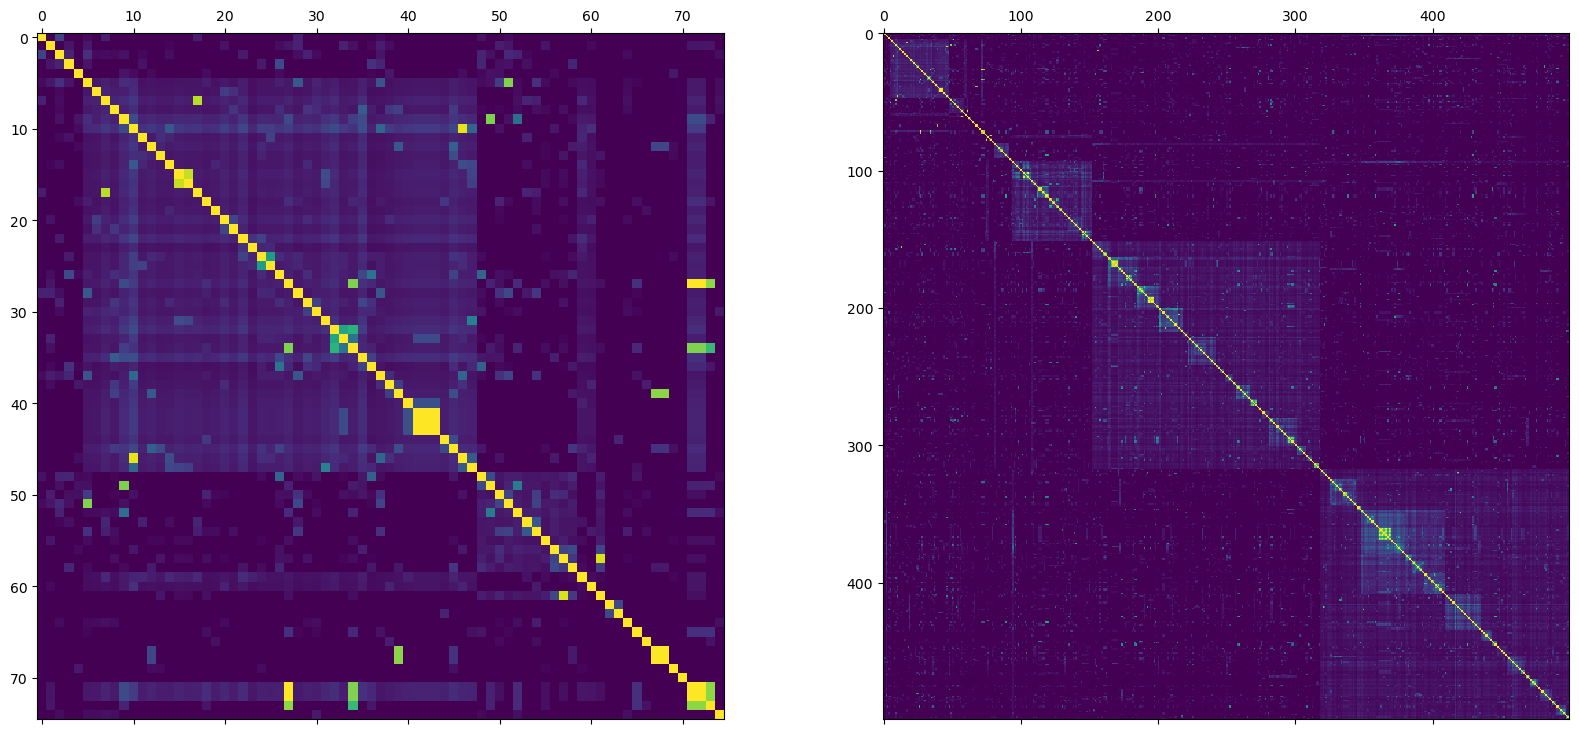

In [20]:
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams['figure.dpi'] = 100
ax1 = plt.subplot(221)
ax1.matshow(distance_matrix_tfidf.todense()[0:75,0:75])
ax2 = plt.subplot(222)
ax2.matshow(distance_matrix_tfidf.todense()[0:500,0:500])

An alternative visualization is to use t-sne method to represent each name in a 2D scatter plot with the distance between each element being proportionnal to the corresponding distance value. Clusters can already being seen in the Figure.

In [21]:
tsne_rslt = TSNE(n_components=2).fit_transform(tf_idf_matrix)

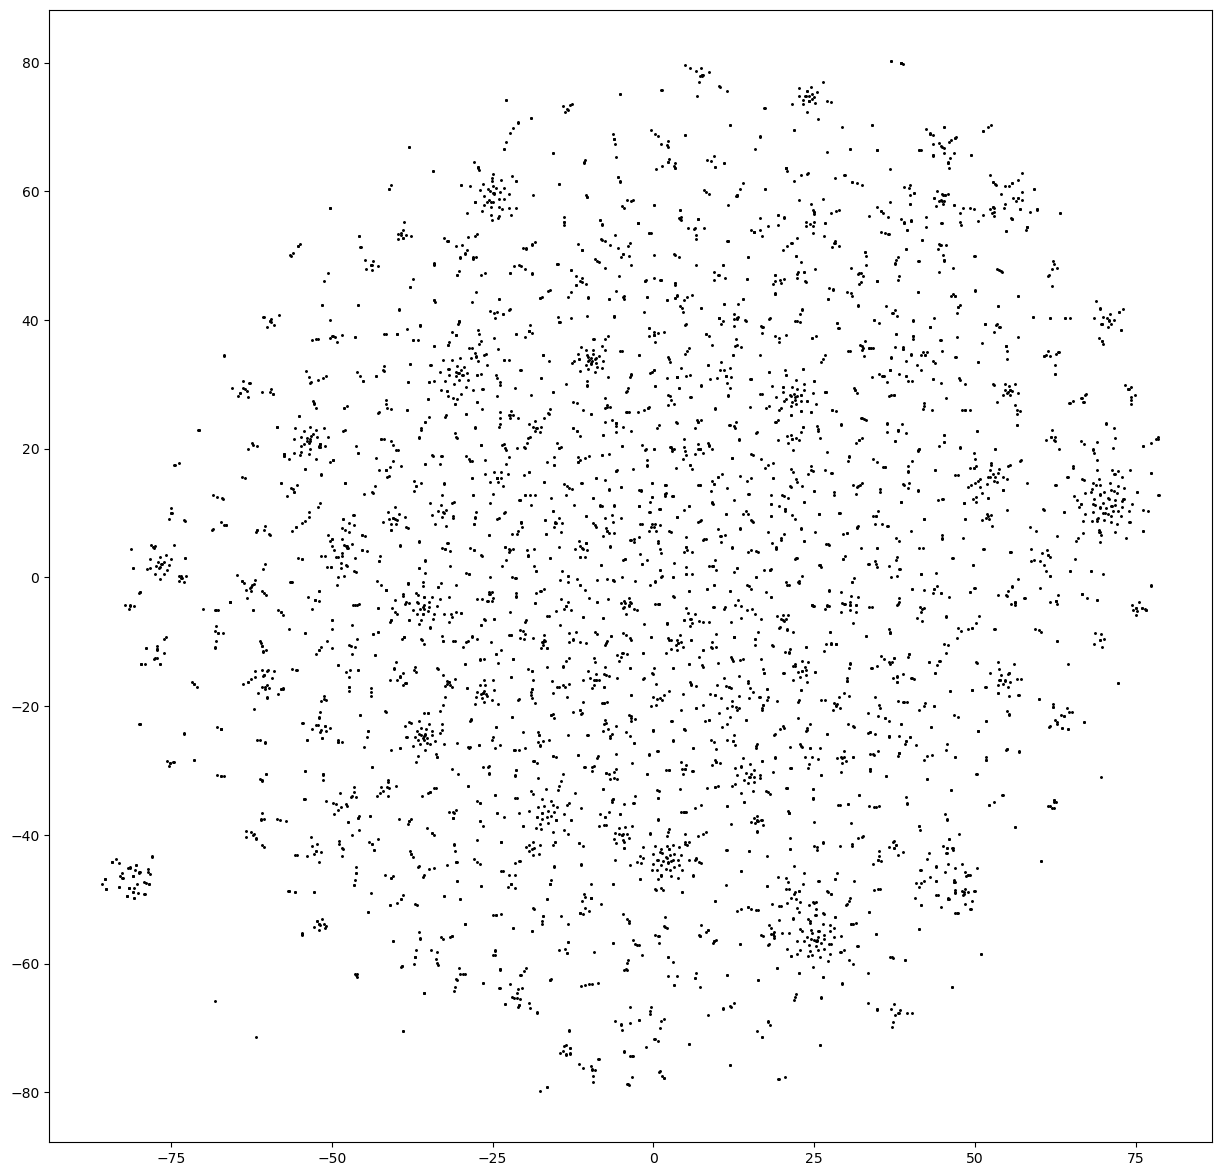

In [22]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 100
plt.scatter(tsne_rslt[:,0], tsne_rslt[:,1], c='k', s=5, marker='.')

## 5. Clustering the names 

A nice comparison of different clustering techniques and their properties are available in the [sklearn documentation](https://scikit-learn.org/stable/modules/clustering.html). For our case study, the hierarchical clustering seems to be the most appropriate as : 1) it is scalable to large number of samples and clusters, 2) we can define a distance threshold where the clustering can be interrupted, and 3) the output can be represented as dendrogram with different layers of clusters.  

In [134]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, fcluster, leaders

The distance matrix (defined as the element-wise `1-similarity` operation) is first computed and will be used as input for the clustering algorithm.

In [42]:
%%time
cosine_distances_tfidf = cosine_distances(tf_idf_matrix)

CPU times: user 217 ms, sys: 107 ms, total: 324 ms
Wall time: 432 ms


The clusterting is then performed using the `sklearn.cluster.AgglomerativeClustering` class. Even if a distance threshold of `0.75` is defined, the algorithm will define the clusters for all distance values (until there is only one cluster remaining with all the elements). Different threshold values will later be used for the final mapping. The affinity parameter is set to `precomputed` as the distance matrix is already computed. 

One of the important hyperparameter of this clustering techniques is the linkage criteria which defined what vector of features to use for a given cluster. This will define the shape the final dendrogram (the size of the clusters and their distance to each others). Here, we set the linkage parameter as `complete`, meaning that the highest distance score is used as the linkage criteria. This ensure to have well-separated final clusters. 

The clustering step takes 1-2 secondes. This step would have to be closely watched when scaled to larger dataset.

In [54]:
%%time
clustering = AgglomerativeClustering(linkage='complete', affinity='precomputed', compute_distances=True,
                                     distance_threshold=0.75, n_clusters=None)
labels = clustering.fit_predict(cosine_distances_tfidf)

CPU times: user 1.45 s, sys: 86.8 ms, total: 1.53 s
Wall time: 2.05 s


The output is a list of cluster id assigned to each element of the dataset. Looking at the first 20 elements, we already see that the 7th element referred as `A & P - LITHOS` is clustered with the 17th referred as `A ET P - LITHOS`, and the 15th and 16th, referred as `A E PETSCHE` and `A E PETSCHE UK LIMITED` are grouped together. As a first glance, it looks like the clustering worked well.

In [55]:
labels[0:20]

array([ 469, 1267,  228,  337,  311,  555, 1519,  897,  212, 1228,   14,
        211, 1366,  258,  410,  800,  800,  897,  834, 1369])

The list of all the clusters (and their element association) can be retrived directly from the clustering class. To manipulate and analyze the result of this clustering, the linkage matrix is built using all the defined links, their distance and the number of associated leaf elements. The resulting matrix is of shape (m-1,4). m-1 is the number of defined clusters. The clusters are sorted by associated distance by definition. See the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage) for more information.

In [57]:
def get_linkage(model):
    # Create linkage matrix and then plot the dendrogram

    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # Define the linkage matrix as ( link element 1, link element 2, distance, counts number  )
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    return linkage_matrix

    
linkage_matrix = get_linkage(clustering)
print(linkage_matrix.shape)
print(linkage_matrix)

(4894, 4)
[[0.000e+00 3.710e+02 0.000e+00 2.000e+00]
 [1.000e+00 1.925e+03 0.000e+00 2.000e+00]
 [2.000e+00 2.578e+03 0.000e+00 2.000e+00]
 ...
 [9.416e+03 9.785e+03 1.000e+00 4.808e+03]
 [9.112e+03 9.786e+03 1.000e+00 4.814e+03]
 [9.428e+03 9.787e+03 1.000e+00 4.895e+03]]


One way to visualize the overall clustering is to convert the cluster labels into colors in the scatter plots. We observe colored clusters,  though it is hard to quatify the quality of this clustering.   

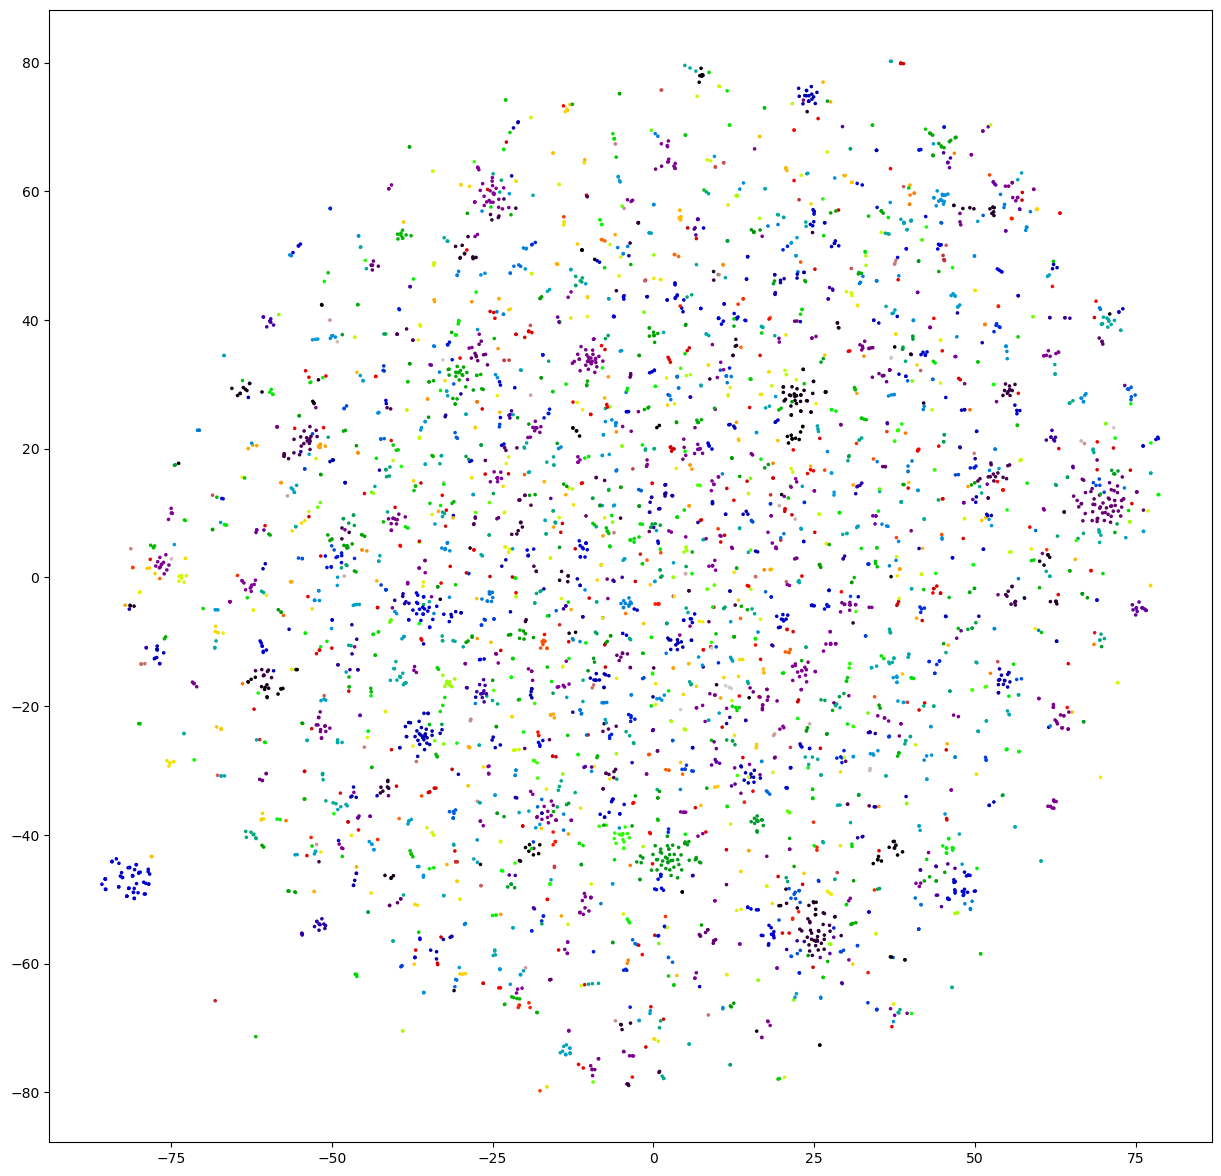

In [68]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 100
plt.scatter(tsne_rslt[:,0], tsne_rslt[:,1], c=labels, marker='.', cmap='nipy_spectral', s=10)

Another way to visalize the result of the clustering is to plot the dendrogram itself using the `scipy` tools. However, since the dataset and the resulting number of clusters are quite large, we have to use a truncated mode. This has the effect of merging the elements at close distance and represent them as leafs in the dendrogram (represented with a number of paranthese which corresponds to the number of merged elements). So only elements and clusters with large distance from each other are represented. This shows a biased version of the outcome of the clustering algorithm with badly clustered elements. 

Below, a representation of this truncated dendrogram is shown with a threshold distance of 0.75. This means that all the links (i.e. clusters) with a distance greater than 0.75 between their elements are colored in blue. The distance between the linked elements are shown in the x axis. 

We can already observe some good clusters such the one associated to `EBERLEIN` in orange or to `ATLASSIAN` in purple. These clusters feature elements with low distance (i.e. shift to the right of the plot). Other bad cluster can also be observed such as the one in grey that merged `ATHOS` with `ARCO ATHOLL` or the green cluster that merged `AUTOVISION ZEITARBEIT` and `AUSZEIT EVENT`. These examples contain common letters sequences (e.g. `ATHO` and `ZEIT`) but their corresponding elements are relatively distant to each others. They ended up to be clustered due to the looser distance threshold applied (0.75). A tuning of this threshold might be important as well as the need to giving the clustering result from different threshold values. 

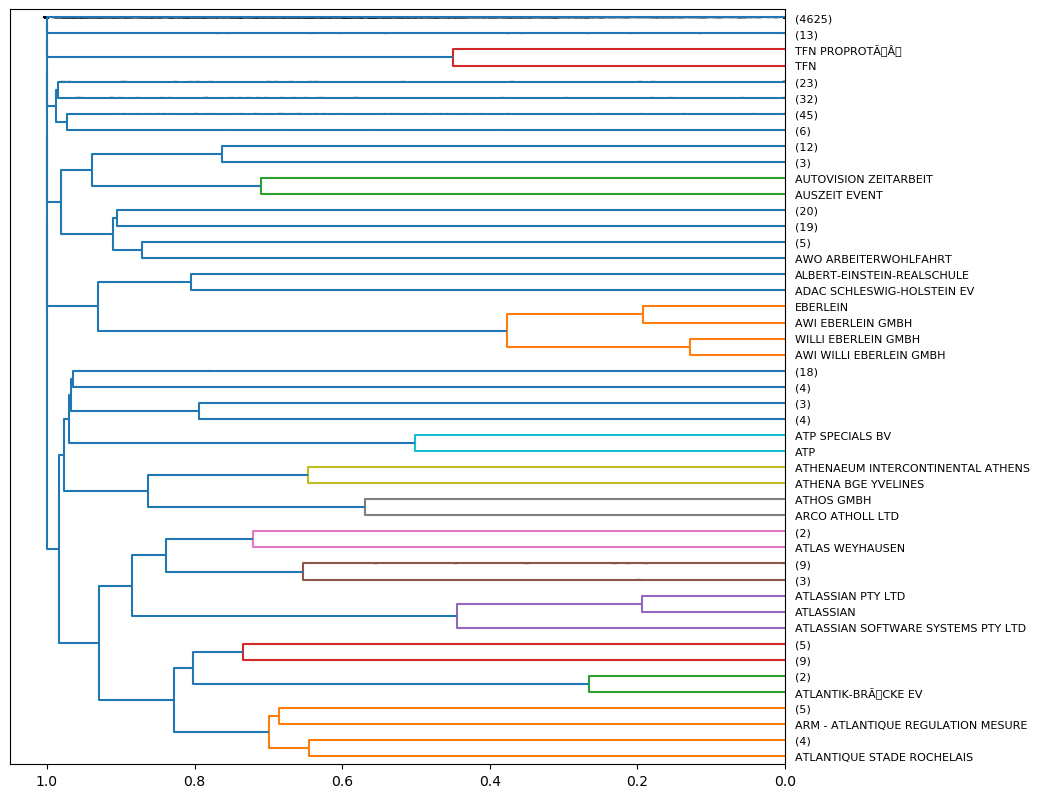

In [154]:
plt.figure(figsize=(10, 10))
dendrogram(linkage_matrix, orientation='left', p=5, truncate_mode='level', color_threshold=0.75,
           labels=data.values, show_contracted=True)
plt.show()

## 6. Presenting the result

In [151]:
# threshold_list = [0.25, 0.4, 0.5, 0.6, 0.7, 0.8]

In [155]:
%%time
threshold = 0.5
fclusters = fcluster(linkage_matrix, threshold, criterion='distance')
leaders_nodes, leaders_labels = leaders(linkage_matrix, fclusters_thld)

CPU times: user 61.3 ms, sys: 0 ns, total: 61.3 ms
Wall time: 139 ms


In [156]:
print(fclusters.shape, fclusters[0:20])
print(leaders_nodes.shape, leaders_nodes[0:20])
print(leaders_labels.shape, leaders_labels[0:20])

(4895,) [3041 2559 1931 2708  504  173 2998 2649 2369  611  811 2355 2273 2611
 2280 2119 2119 2649 2761 2055]
(3087,) [6256 6373 4012 3234 5589 3996 3997 3989 6606 3993 3999 3991 3992 3998
 5531 5778 6068 6452 4028 6471]
(3087,) [ 1  2  3  5  4  7  8 10  9 11 12 14 15 16 13  6 19 20 21 18]


In [180]:
print(fclusters[leaders_nodes[2]], data.at[fclusters[leaders_nodes[2]]])

3 "ANTERAL, SL"


In [221]:
def get_leafs_recursively(node_id, linkage_matrix, data):
    leafs = []
    n_names = data.shape[0]
    if node_id < n_names:
        leafs.append(data.at[node_id])
    else:
        leafs += get_leafs_recursively(int(linkage_matrix[node_id-n_names,0]), linkage_matrix, data)
        leafs += get_leafs_recursively(int(linkage_matrix[node_id-n_names,1]), linkage_matrix, data)
    return leafs

In [222]:
print(get_leafs_recursively(leaders_nodes[4], linkage_matrix, data))

['ATLANTIQUE AUTOMATISME INCENDIE', 'ATLANTIQUE AUTOMATISMES INCENDIE', 'AAI ATLANTIQUE AUTOMATISMES INCENDI', 'AAI - ATLANTIQUE AUTOMATISMES INCENDIE', 'AAI ATLANTIQUE AUTOMATISMES INCENDIE']


## 7. Evaluating the performance